In [1]:
import numpy as np
import pandas as pd
import os

dfs = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        df = pd.read_csv(path, delimiter='|')
        if 'id' in df.columns:
            df.drop(['id'], axis=1, inplace=True)
        dfs.append(df)

In [2]:
df = pd.concat(dfs, ignore_index=True)

In [3]:
df.dropna(axis=1, how='all', inplace=True)

In [5]:
df.fillna('', axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89132 entries, 0 to 89131
Columns: 185 entries, nct_id to calculate_percentage
dtypes: float64(33), object(152)
memory usage: 125.8+ MB


In [7]:
str_columns = []
float_columns = []

for col in df.columns:
    d = df[col].dtype
    if d is df['nct_id'].dtype:
        str_columns.append(col)
    else:
        float_columns.append(col)
        
print(len(str_columns))
print(len(float_columns))

152
33


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

numeric_df = df[float_columns]

numeric_df.fillna(0, inplace=True)

scaler = StandardScaler()
numeric_df_scaled = scaler.fit_transform(numeric_df)

text_df = df[str_columns]

text_df.fillna("", inplace=True)

/tmp/ipykernel_47/3340096102.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df.fillna(0, inplace=True)
/tmp/ipykernel_47/3340096102.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df.fillna("", inplace=True)


In [9]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
text_features = vectorizer.fit_transform(text_df.apply(lambda x: ' '.join(x), axis=1))

In [10]:
combined_features = pd.concat([pd.DataFrame(numeric_df_scaled, columns=numeric_df.columns), pd.DataFrame(text_features.toarray(), columns=vectorizer.get_feature_names_out())], axis=1)

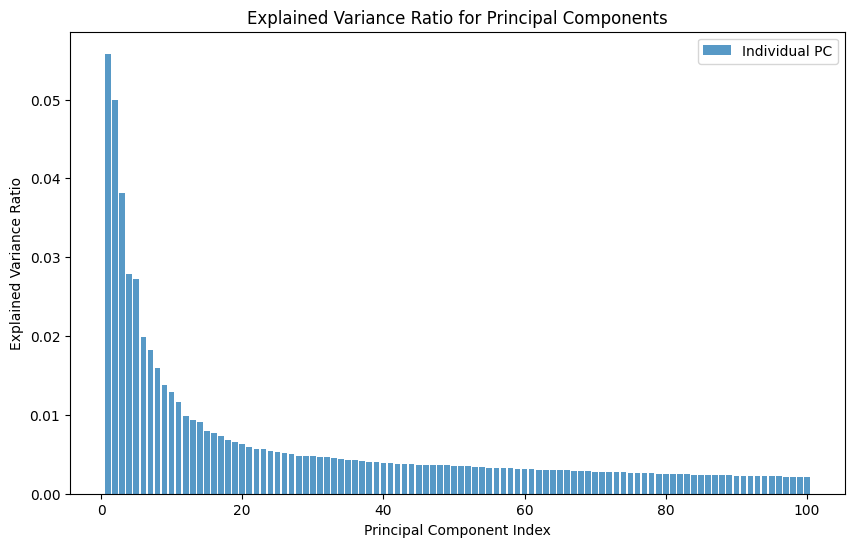

In [11]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
combined_features_standardized = scaler.fit_transform(combined_features)

pca = PCA()
pca_result = pca.fit_transform(combined_features_standardized)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(1, 101), explained_variance_ratio[:100], alpha=0.75, align='center', label='Individual PC')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Principal Components')
plt.legend()
plt.show()

We already know that number of clusters = 6, is optimal using 'CSD361-Project-Shruti - finding optimal number of clusters.ipynb'

In [12]:
from sklearn.metrics import calinski_harabasz_score

num_components_to_select = 5
selected_pca_features = pca_result[:, :num_components_to_select]

kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(selected_pca_features)
silhouette_score_val = silhouette_score(selected_pca_features, labels)
calinski_harabasz_score_val = calinski_harabasz_score(selected_pca_features, labels)

print(silhouette_score_val)
print(calinski_harabasz_score_val)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.8848793775610343
280183.7422952815


In [18]:
selected_pca_features

array([[-2.10057517, -0.9199404 , -1.1759682 , -0.76371344, -0.15294931],
       [-2.03990548, -1.10223352, -1.4700473 ,  0.159822  , -0.97471549],
       [-1.81685812, -0.99235383, -1.28025685,  0.20057354, -0.87197645],
       ...,
       [-1.62157673, -1.08090468, -1.44898743,  0.58753566, -0.26561711],
       [-0.29752272, -1.177886  , -1.37637211,  0.5277085 , -0.43833327],
       [-0.29752272, -1.177886  , -1.3763721 ,  0.5277085 , -0.43833327]])

In [23]:
original_feature_indices = range(num_components_to_select)
feature_names = [f'PC_{i}' for i in original_feature_indices]

ordered_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for cluster_num in range(6):
    key_features = [feature_names[index] for index in ordered_centroids[cluster_num, :]]

    print(f'Cluster #{cluster_num + 1}')
    print('Key Features:', key_features)
    print('-' * 80)

Cluster #1
Key Features: ['PC_3', 'PC_4', 'PC_1', 'PC_2', 'PC_0']
--------------------------------------------------------------------------------
Cluster #2
Key Features: ['PC_1', 'PC_3', 'PC_0', 'PC_4', 'PC_2']
--------------------------------------------------------------------------------
Cluster #3
Key Features: ['PC_4', 'PC_3', 'PC_1', 'PC_0', 'PC_2']
--------------------------------------------------------------------------------
Cluster #4
Key Features: ['PC_2', 'PC_3', 'PC_1', 'PC_0', 'PC_4']
--------------------------------------------------------------------------------
Cluster #5
Key Features: ['PC_4', 'PC_2', 'PC_1', 'PC_0', 'PC_3']
--------------------------------------------------------------------------------
Cluster #6
Key Features: ['PC_0', 'PC_3', 'PC_4', 'PC_2', 'PC_1']
--------------------------------------------------------------------------------


In [24]:
for pc_index in range(num_components_to_select):
    loadings = pca.components_[pc_index]
    loading_df = pd.DataFrame({'Feature': combined_features.columns, 'Loading': loadings})
    loading_df = loading_df.reindex(loading_df['Loading'].abs().sort_values(ascending=False).index)
    top_features = loading_df.head(10)
    print(f'PC_{pc_index}')
    print(top_features)
    print('-' * 80)

PC_0
          Feature   Loading
277      included  0.176921
459           set  0.176414
159       cohorts  0.174524
179        cutoff  0.173422
84             61  0.172650
85             64  0.171291
76             35  0.169822
79             47  0.169044
444  respectively  0.167595
112           apr  0.166366
--------------------------------------------------------------------------------
PC_1
            Feature   Loading
442         reports  0.186166
166        concepts  0.186049
488  systematically  0.185795
135        captured  0.185343
177              cu  0.185146
118     attribution  0.182574
212              dw  0.179919
301          jensen  0.178443
46              124  0.177844
53              188  0.177055
--------------------------------------------------------------------------------
PC_2
           Feature   Loading
197     dictionary  0.205086
192  deterioration  0.204844
516       untoward  0.203188
339      medicinal  0.202834
236       existing  0.202227
211     dur